# Calculating trainsition states

Identifying the most compute effective approach to calculating transition states can be difficult. Let us guide you through the options in this short notebook. **Pre-requisite: Familiarity with ASE**

First, let us create a toy model of Au FCC(111) surface and 2 Cu ad atoms. 

In [1]:
from examples.data.model_gen import get_example_slab
slab_initial = get_example_slab(adsorbate=True, type="2Cu")

In the model above the two Cu atoms are situated on top of hcp adsorption sites. The final geometry will be with copper atoms placed in non-neighbouring fcc and hcp sites. The goal is to calculate the transition state between the two and an activation energy.

In [2]:
slab_final = get_example_slab(adsorbate=True, type="2Cu")
hcp_position = [slab_final[1].x, (slab_final[15].y + slab_final[1].y)/2]
# place the copper atom in the position specified above
slab_final[19].x, slab_final[19].y = hcp_position[0], hcp_position[1]

Now before we proceed we need to make sure the structures are optimised. Forces convergence criterion is usually below 0.01 eV/Angstrom on each individual atom, but for the purposes of this tutorial a looser 0.05 value is used.

In [3]:
from ase.optimize import FIRE
from ase.constraints import FixAtoms
# For the purpose of this tutorial a  constraint is set for all of the surface atoms
# Constraints used should always be specific to your system and applied following tests
freeze = FixAtoms([atom.index for atom in slab_initial if atom.tag > 0])
slab_initial.set_constraint(freeze)
slab_final.set_constraint(freeze)

opt = FIRE(slab_initial, trajectory="slab_initial.traj", restart="slab_initial.pckl")
opt.run(fmax=0.05)
opt = FIRE(slab_final, trajectory="slab_final.traj", restart="slab_final.pckl")
opt.run(fmax=0.05)

# You can have a look at the model using the visualizer
from ase.visualize import view
#view(slab_initial)
#view(slab_final)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 10:53:08        9.933133*       1.8648
FIRE:    1 10:53:08        9.850970*       1.9097
FIRE:    2 10:53:08        9.692007*       1.9892
FIRE:    3 10:53:08        9.445897*       2.0727
FIRE:    4 10:53:08        9.109953*       2.0426
FIRE:    5 10:53:08        8.736395*       1.5262
FIRE:    6 10:53:08        8.561001*       0.9843
FIRE:    7 10:53:08        8.556259*       0.9464
FIRE:    8 10:53:08        8.547484*       0.8807
FIRE:    9 10:53:08        8.535801*       0.8061
FIRE:   10 10:53:08        8.522307*       0.7456
FIRE:   11 10:53:08        8.507640*       0.7169
FIRE:   12 10:53:08        8.491767*       0.7227
FIRE:   13 10:53:09        8.474069*       0.7510
FIRE:   14 10:53:09        8.451284*       0.7894
FIRE:   15 10:53:09        8.420934*       0.8250
FIRE:   16 10:53:09        8.380019*       0.8492
FIRE:   17 10:53:09        8.325273*       0.8621
FI

Now that we have the structures prepared, we need to look for an activation energy for transition between slab_initial and slab_final.

There are multiple ways one can approach this problem, but all will in the end help to establish highest energy geometry linking these two structures - the transition state.

    a.) NEB
    b.) MLNEB
    c.) AutoNEB
    d.) Surface diffusion energy barriers using ASE constraints - fixed plane
    e.) Surface diffusion energy barriers using ASE constraints - fixed bond lengths
    f.) Dimer Method (and Improved Dimer Method)
    g.) Growing String method
    h.) More are being developed

a.) Nudged Elastic Band - NEB

"The Nudged Elastic Band method is a technique for finding transition paths (and corresponding energy barriers) between given initial and final states. The method involves constructing a “chain” of “replicas” or “images” of the system and relaxing them in a certain way."

Detailed description of the NEB class as implemented in ASE, including useful publications:
https://wiki.fysik.dtu.dk/ase/ase/neb.html?highlight=neb#module-ase.neb
ASE take on this tutorial, exploring the functionality a bit more:
https://wiki.fysik.dtu.dk/ase/tutorials/neb/diffusion.html

The "classic" NEB is a bit of a brute force approach. It takes a lot of trial and error to get below convergence criteria and it is costly. All of the "images" mentioned above are optimised per iteration, so if one is interested in getting to know the Minimum Energy Path (MEP) better, often number of DFT calculations goes into thousands.

One of the problems associated with NEBs in general is that they rely heavily on the user-provided input structures. If they are not optimal due to complexity of the process, the MEP is elongated and the overall experiment becomes more expensive. There are ways of improving initial/final guesses, but not as straightforward with regular NEB.

To overcome the complexity of the energy landscape we need to focus solely on the highest energy transition state and ignore the lesser maxima, which can arise due to rotations etc. For this we use a *climbing image* calculation (see NEB wiki for more info).

In [4]:
# a) NEB code in ASE
from ase.neb import NEB
from ase.calculators.emt import EMT
import copy

# Make a band consisting of 7 images (including initial and final)
# Very important - each image has to have a separate calculator!
# If one wants to use a single calculator, e.g. sockets with FHI-aims,
# the SingleCalculatorNEB class needs to be used in instead
images = [slab_initial]
images += [slab_initial.copy() for i in range(5)]
images += [slab_final]
neb = NEB(images, climb=True) # use climbing image calculation
# Interpolate linearly the potisions of the three middle images:
neb.interpolate()
# Set calculators:
for image in images[1:6]:
    image.set_calculator(EMT())

# Optimize:
optimizer = FIRE(neb,
                trajectory='A2B.traj' # when running a real calculation make sure to save the output!
                 )
optimizer.run(fmax=0.05)

# Use ASE GUI to view the MEP
#view(images)


      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 10:53:13        7.454145*       0.8369
FIRE:    1 10:53:13        7.447736*       0.7491
FIRE:    2 10:53:13        7.437564*       0.5899
FIRE:    3 10:53:14        7.427612*       0.3875
FIRE:    4 10:53:14        7.421407*       0.1820
FIRE:    5 10:53:14        7.420673*       0.1199
FIRE:    6 10:53:14        7.420675*       0.1189
FIRE:    7 10:53:14        7.420679*       0.1170
FIRE:    8 10:53:14        7.420687*       0.1142
FIRE:    9 10:53:14        7.420702*       0.1107
FIRE:   10 10:53:15        7.420728*       0.1066
FIRE:   11 10:53:15        7.420767*       0.1021
FIRE:   12 10:53:15        7.420823*       0.0974
FIRE:   13 10:53:15        7.420908*       0.0923
FIRE:   14 10:53:15        7.421035*       0.0871
FIRE:   15 10:53:16        7.421216*       0.0823
FIRE:   16 10:53:16        7.421464*       0.0783
FIRE:   17 10:53:16        7.421786*       0.0752
FI

True

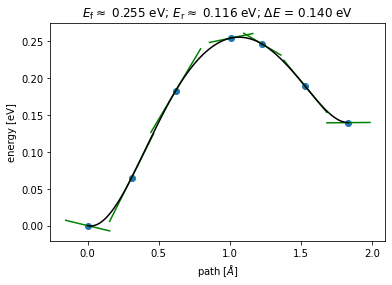

In [9]:
# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools

nebtools = NEBTools(images)

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band() # TODO: Why is this not generated when only runs once in Jupyter Notebook?
fig.savefig('barrier-neb.png')

b) Machine Learning NEB by CatLearn (MLNEB)

NEB images are generated and added dynamically based on the Gaussian Training Process. Each image is a product of a single-point calculation rather than optimisation. Overall efficiency in terms of resources should be increased by an order of magnitude.

If you use CatLearn's ML-NEB module, please cite:

   J. A. Garrido Torres, M. H. Hansen, P. C. Jennings,
   J. R. Boes and T. Bligaard. Phys. Rev. Lett. 122, 156001.
   https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.122.156001

In [6]:
from catlearn.optimize.mlneb import MLNEB
from ase.calculators.emt import EMT

# Desired nuber of images including start and end point
# Can be fraction e.g. 0.25, then the number of imaages is then determined automatically based on MEP length
n = 7 

calculator = EMT()
interpolation = "idpp" #or your own supplied path

# Setup the Catlearn object for MLNEB
neb_catlearn = MLNEB(start=slab_initial,
                     end=slab_final,
                     ase_calc=calculator,
                     n_images=n,
                     interpolation=interpolation, restart=False) #When True looks for evaluated_structures.traj

# Run the NEB optimisation. Adjust fmax to desired convergence criteria, usually 0.01 ev/A
neb_catlearn.run(fmax=0.05, trajectory='ML-NEB.traj', full_output=False, steps=75)

# Warning, this calculation takes some time on a local system, but it is little compared to DFT calculations
# on periodic surface models. Might not be ideal for trivial systems, e.g. small molecules in the gas phase.



/home/igor/.local/lib/python3.6/site-packages/ase/parallel.py:342: FutureWarning: ase.parallel.rank has been deprecated.  Please use ase.parallel.world.rank instead.
  FutureWarning)
/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)
/home/igor/.local/lib/python3.6/site-packages/ase/atoms.py:921: VisibleDeprecationWarning: Use get_global_number_of_atoms() instead
  np.VisibleDeprecationWarning)


 
       ____      _   _                          
      / ___|__ _| |_| |    ___  __ _ _ __ _ __  
     | |   / _` | __| |   / _ \/ _` | '__| '_ \ 
     | |__| (_| | |_| |__|  __/ (_| | |  | | | |
      \____\__,_|\__|_____\___|\__,_|_|  |_| |_| ML-NEB 0.6.2
      
      
+--------+------+---------------------+---------------------+---------------------+--------------+--------------+----------+
| Method | Step |        Time         | Pred. barrier (-->) | Pred. barrier (<--) | Max. uncert. | Avg. uncert. |   fmax   |
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
| ML-NEB |     0| 2020-07-01 10:53:19 |             0.000000|             0.000000|      0.000000|      0.000000|  0.021585|
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
+--------+------+---------------------+---------------------+---------------------+--------------+---------

/home/igor/.local/lib/python3.6/site-packages/scipy/optimize/_numdiff.py:519: RuntimeWarning: invalid value encountered in true_divide
  J_transposed[i] = df / dx




+--------+------+---------------------+---------------------+---------------------+--------------+--------------+----------+
| Method | Step |        Time         | Pred. barrier (-->) | Pred. barrier (<--) | Max. uncert. | Avg. uncert. |   fmax   |
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+
| ML-NEB |     0| 2020-07-01 10:53:25 |             0.000000|             0.000000|      0.000000|      0.000000|  0.021585|
| ML-NEB |     1| 2020-07-01 10:53:25 |             0.000000|             0.000000|      0.000000|      0.000000|  0.733858|
| ML-NEB |     2| 2020-07-01 10:53:25 |             0.143220|             0.003680|      0.095560|      0.053720|  1.799284|
+--------+------+---------------------+---------------------+------------------+--------------+--------------+----------+


Training a Gaussian process...
Number of training points: 4
Gaussian process trained.


+--------+------+---------------------+

In [7]:
# Check the output of MLNEB
from ase.io import read
#view(read("ML-NEB.traj@:"))

/home/igor/.local/lib/python3.6/site-packages/ase/io/jsonio.py:122: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  a = np.array(obj)


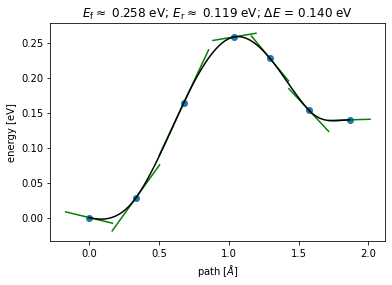

In [8]:
# Now let's analyse the output, if dealing with one calculation it is sufficient to use
# ASE GUI and choose Tools --> NEB to see the plot

import matplotlib.pyplot as plt
from ase.neb import NEBTools
from ase.io import read

nebtools = NEBTools(read("ML-NEB.traj@:"))

# Get the calculated barrier and the energy change of the reaction.
Ef, dE = nebtools.get_barrier()

# Get the actual maximum force at this point in the simulation.
max_force = nebtools.get_fmax()

# Create a figure like that coming from ASE-GUI.
fig = nebtools.plot_band()
fig.savefig('barrier-mlneb.png')


# TODO: neb(✓), mlneb(✓), linear scan, (also Growing string?, Dimer method?)
# TODO: discuss indices in input structures (CO2 as example, avoid rotation during neb
# TODO: discuss symmetry operations (where possible) to reduce path size
# TODO: discuss difficult energy landscape, optimisations of local minima, dissociation with fixed bond lengths